Modeling

Loading library & Data-set

In [2]:
# === Import Python library
import os
import pandas as pd
import numpy as np
import librosa
import librosa.display as lid
import matplotlib.pyplot as plt
import IPython.display as ipd
from matplotlib import cm
from tqdm import tqdm
tqdm.pandas()
import torch
import torch.nn as nn
import torchvision.transforms as transforms
from torchvision import models
from torch.utils.data import Dataset, DataLoader
from PIL import Image
import random
import torchaudio
from torchvision import transforms
from torchaudio.transforms import MelSpectrogram

# ====Loading data
# pip install nbimporter
DATA_DIR = 'E:/Desktop/BU/2025 Spring/MA679_Bird2025/'
train_meta = pd.read_csv(os.path.join(DATA_DIR, 'train.csv'))
submission_path = 'sample_submission.csv'
sub = pd.read_csv(submission_path)
# Label info
class_names = sorted(train_meta['primary_label'].unique())
name2id = {name: i for i, name in enumerate(class_names)}
id2name = {i: name for name, i in name2id.items()}

Configuration

In [3]:
class CFG:
    seed = 42
    img_size = [128, 384]
    batch_size = 64
    duration = 15
    sample_rate = 32000
    audio_len = duration * sample_rate
    nfft = 2028
    window = 1024
    hop_length = audio_len // (img_size[1] - 1)
    fmin = 20
    fmax = 16000
    epochs = 10
    preset = 'efficientnetv2_b2_imagenet'
    augment = True

cmap = cm.get_cmap('coolwarm')

C:\Users\mlsdb\AppData\Local\Temp\ipykernel_20496\2906471814.py:17: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap('coolwarm')


Functions

In [4]:
def extract_mel_label(row):
    filepath = os.path.join(DATA_DIR, 'train_audio', row['filename'])  # 
    try:
        audio, _ = load_audio(filepath)
        mel = audio_to_mel(audio)
        label = name2id[row['primary_label']]
        return mel, label
    except Exception as e:
        print(f"Error processing {filepath}: {e}")
        return None, None


def load_audio(filepath):
    audio, sr = librosa.load(filepath, sr=CFG.sample_rate)
    if len(audio) < CFG.audio_len:
        audio = np.pad(audio, (0, CFG.audio_len - len(audio)))
    else:
        audio = audio[:CFG.audio_len]
    return audio, sr

def audio_to_mel(audio):
    mel = librosa.feature.melspectrogram(
        y=audio,
        sr=CFG.sample_rate,
        n_fft=CFG.nfft,
        hop_length=CFG.hop_length,
        win_length=CFG.window,
        n_mels=CFG.img_size[0],
        fmin=CFG.fmin,
        fmax=CFG.fmax
    )
    mel_db = librosa.power_to_db(mel, ref=np.max)
    mel_db -= mel_db.min()
    mel_db /= mel_db.max()
    return mel_db

def save_mel_as_image(mel, save_path):
    plt.figure(figsize=(4, 2))
    plt.axis('off')
    librosa.display.specshow(mel, sr=CFG.sample_rate, hop_length=CFG.hop_length,
                             x_axis='time', y_axis='mel', cmap='magma')
    plt.savefig(save_path, bbox_inches='tight', pad_inches=0)
    plt.close()

class SpectrogramImageDataset(Dataset):
    def __init__(self, image_dir, transform=None):
        self.image_dir = image_dir
        self.image_files = [f for f in os.listdir(image_dir) if f.endswith(".png")]
        self.transform = transform
        # Extract class names from file (e.g., '03_amecro.png' → 'amecro')
        self.class_names = sorted(list({f.split('_')[1].split('.')[0] for f in self.image_files}))
        self.name2id = {name: i for i, name in enumerate(self.class_names)}
    
    def __len__(self):
        return len(self.image_files)
    
    def __getitem__(self, idx):
        file = self.image_files[idx]
        img_path = os.path.join(self.image_dir, file)
        image = Image.open(img_path).convert("RGB")
        if self.transform:
            image = self.transform(image)
        label_name = file.split('_')[1].split('.')[0]
        label = torch.tensor(self.name2id[label_name])
        return image, label

def audio_to_mel_image(audio_path, save_path):
    y, sr = librosa.load(audio_path, sr=CFG.sample_rate)
    y = y[:CFG.audio_len]
    mel = librosa.feature.melspectrogram(
        y=y,
        sr=CFG.sample_rate,
        n_fft=CFG.nfft,
        hop_length=CFG.hop_length,
        win_length=CFG.window,
        n_mels=CFG.img_size[0],
        fmin=CFG.fmin,
        fmax=CFG.fmax
    )
    mel_db = librosa.power_to_db(mel, ref=np.max)
    mel_img = (mel_db - mel_db.min()) / (mel_db.max() - mel_db.min())
    plt.imsave(save_path, mel_img, cmap='viridis')



Display sample 1 

Mel shape: (128, 384)
Label (class id): 0 | Label name: 1139490


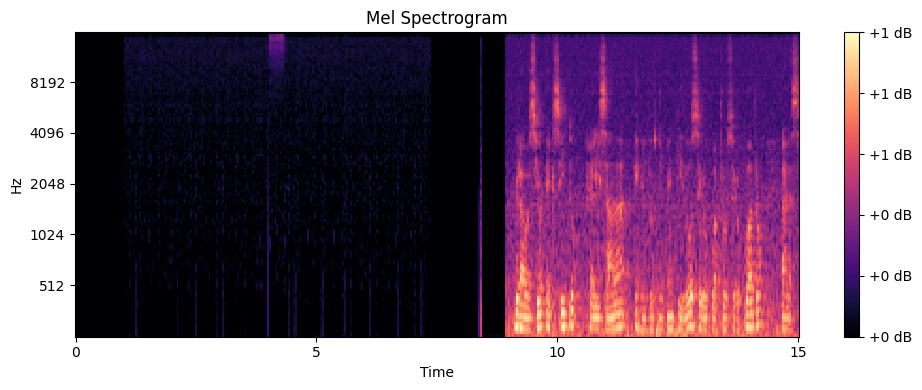

In [5]:
row = train_meta.iloc[0]

# Extract mel and label
mel, label = extract_mel_label(row)

# Check if successful
if mel is not None:
    print("Mel shape:", mel.shape)
    print("Label (class id):", label, "| Label name:", id2name[label])

    # Plot the mel spectrogram
    plt.figure(figsize=(10, 4))
    librosa.display.specshow(mel, sr=CFG.sample_rate, hop_length=CFG.hop_length,
                             fmin=CFG.fmin, fmax=CFG.fmax,
                             x_axis='time', y_axis='mel', cmap='magma')
    plt.colorbar(format='%+2.0f dB')
    plt.title('Mel Spectrogram')
    plt.tight_layout()
    plt.show()

Store sample image to Local(15000)

Error with E:/Desktop/BU/2025 Spring/MA679_Bird2025/train_audio\pirfly1/XC570839.ogg: Unable to allocate 7.77 MiB for an array with shape (2037504,) and data type float32
Error with E:/Desktop/BU/2025 Spring/MA679_Bird2025/train_audio\pirfly1/XC571696.ogg: Unable to allocate 1.94 MiB for an array with shape (2037504,) and data type bool
Error with E:/Desktop/BU/2025 Spring/MA679_Bird2025/train_audio\pirfly1/XC574619.ogg: Unable to allocate 7.10 MiB for an array with shape (1861590,) and data type float32
Error with E:/Desktop/BU/2025 Spring/MA679_Bird2025/train_audio\pirfly1/XC575453.ogg: Unable to allocate 7.14 MiB for an array with shape (1872384,) and data type float32
Error with E:/Desktop/BU/2025 Spring/MA679_Bird2025/train_audio\pirfly1/XC580708.ogg: Unable to allocate 2.21 MiB for an array with shape (580127,) and data type float32
Error with E:/Desktop/BU/2025 Spring/MA679_Bird2025/train_audio\pirfly1/XC589780.ogg: Unable to allocate 17.2 MiB for an array with shape (4507264,) 

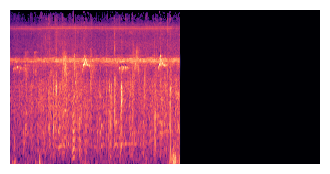

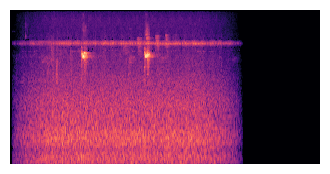

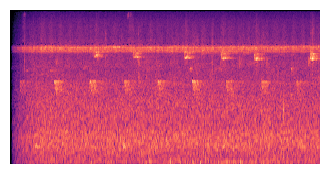

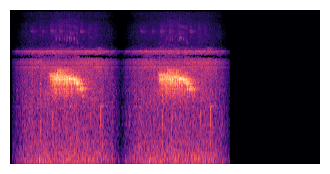

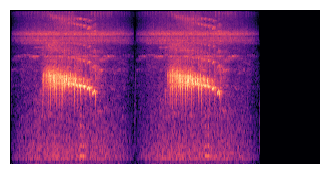

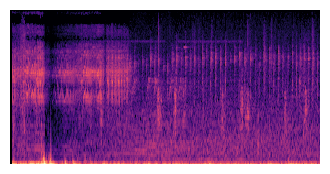

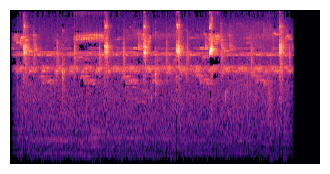

In [ ]:
# for i in range(15000):
#     row = train_meta.iloc[i]
#     filepath = os.path.join(DATA_DIR, 'train_audio', row['filename'])
    
#     try:
#         audio, sr = load_audio(filepath)
#         mel = audio_to_mel(audio)
        
#         plt.figure(figsize=(4, 2))
#         plt.axis('off')
#         librosa.display.specshow(mel, sr=sr, hop_length=CFG.hop_length,
#                                  x_axis='time', y_axis='mel', cmap='magma')
#         plt.savefig(f'Local/{i:02d}_{row["primary_label"]}.png', bbox_inches='tight', pad_inches=0)
#         plt.close()
#     except Exception as e:
#         print(f"Error with {filepath}: {e}")

Feedin

In [5]:
# ResNet formatting(224*224)
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
])

# Load Dataset and DataLoader ===
dataset = SpectrogramImageDataset('Local', transform=transform)
dataloader = DataLoader(dataset, batch_size=4, shuffle=True)

# === Load Pretrained ResNet18 and Adapt for Bird Classes ===
model = models.resnet18(weights=models.ResNet18_Weights.DEFAULT)
model.fc = nn.Linear(model.fc.in_features, len(dataset.class_names))  # num_classes = bird species

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# === Optimizer and Loss ===
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

# === Training Loop (3 epochs)
model.train()
for epoch in range(3):
    total_loss = 0.0
    correct = 0
    total = 0
    for images, labels in dataloader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
        preds = outputs.argmax(dim=1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)
    acc = 100 * correct / total
    print(f"Epoch {epoch+1}, Loss: {total_loss:.4f}, Accuracy: {acc:.2f}%")

Epoch 1, Loss: 9418.6241, Accuracy: 44.70%
Epoch 2, Loss: 5577.7251, Accuracy: 65.57%
Epoch 3, Loss: 3956.6331, Accuracy: 74.79%


In [ ]:
import os
import librosa
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import torch
import pandas as pd

# === Setup paths ===
soundscape_dir = 'train_soundscapes'
output_dir = 'Local/test_spectrograms'
os.makedirs(output_dir, exist_ok=True)

# === all soundscape files ===
ogg_files = [f for f in os.listdir(soundscape_dir) if f.endswith('.ogg')][:]

# === Define function: Convert audio to mel spectrogram and save ===
def audio_to_mel_image(audio_path, save_path):
    y, sr = librosa.load(audio_path, sr=CFG.sample_rate)
    y = y[:CFG.audio_len]
    mel = librosa.feature.melspectrogram(
        y=y,
        sr=CFG.sample_rate,
        n_fft=CFG.nfft,
        hop_length=CFG.hop_length,
        win_length=CFG.window,
        n_mels=CFG.img_size[0],
        fmin=CFG.fmin,
        fmax=CFG.fmax
    )
    mel_db = librosa.power_to_db(mel, ref=np.max)
    mel_img = (mel_db - mel_db.min()) / (mel_db.max() - mel_db.min())
    plt.imsave(save_path, mel_img, cmap='viridis')

# === Prepare submission file ===
sub = pd.read_csv('sample_submission.csv')

# === Loop through audio files ===
for i, file_name in enumerate(ogg_files):
    audio_path = os.path.join(soundscape_dir, file_name)
    img_path = os.path.join(output_dir, file_name.replace('.ogg', '.jpg'))

    # Generate mel spectrogram image
    audio_to_mel_image(audio_path, img_path)

    # Run inference
    image = Image.open(img_path).convert('RGB')
    image_tensor = transform(image).unsqueeze(0).to(device)

    model.eval()
    with torch.no_grad():
        output = model(image_tensor)
        probs = torch.sigmoid(output).squeeze().cpu().numpy()

    # Fill submission with prediction
    sub.at[i, 'row_id'] = file_name.replace('.ogg', '')
    for j, col in enumerate(sub.columns[1:]):
        sub.at[i, col] = probs[j] if j < len(probs) else 0.0

# === Save final CSV ===
sub.to_csv('submission500.csv', index=False)
print(" submission500.csv saved with predictions for 10 soundscapes.")


✅ submission500.csv saved with predictions for 10 soundscapes.


Build a pytorch custom Dataset

In [ ]:
spectrogram_dir = "Local"
output_csv = "metadata.csv"

# === Extract metadata ===
rows = []
for file in os.listdir(spectrogram_dir):
    if file.endswith(".png"):
        idx, name = file.replace(".png", "").split("_")
        label = name 
        rows.append({
            "file_name": file,
            "label": label  # This can be int(label) if it's numeric
        })

# === Create and Save CSV ===
df = pd.DataFrame(rows)
df.to_csv(output_csv, index=False)

print(f"metadata.csv saved with {len(df)} rows.")

metadata.csv saved with 14938 rows.


Glimse of metadata

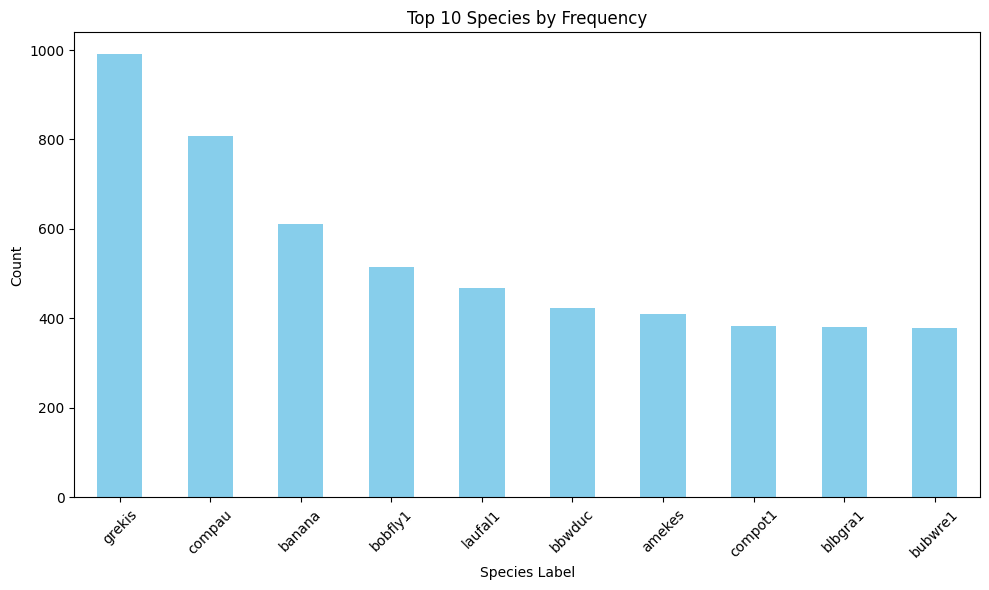

In [10]:
metadata = pd.read_csv("metadata.csv")
top_species = metadata['label'].value_counts().head(10)

# Plot the top 10 species
plt.figure(figsize=(10, 6))
top_species.plot(kind='bar', color='skyblue')
plt.title('Top 10 Species by Frequency')
plt.xlabel('Species Label')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [11]:
class MelSpectrogramDataset(Dataset):
    def __init__(self, dataframe, root_dir, transform=None):
        self.dataframe = dataframe
        self.root_dir = root_dir
        self.transform = transform

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        img_name = os.path.join(self.root_dir, self.dataframe.iloc[idx, 0])
        image = Image.open(img_name).convert('RGB')
        label = int(self.dataframe.iloc[idx, 1])
        
        if self.transform:
            image = self.transform(image)
        
        return image, label